![Data Clean and FE](../img/03.png)

# Data Cleaning & Feature Engineering

## Objective
Clean the dataset, handle missing values, and engineer features for machine learning models.

## Contents
1. Data Quality Assessment
2. Missing Value Treatment
3. Text Data Preprocessing
4. Feature Engineering
   - Binary Features (warnings)
   - Text-Derived Features
   - Aggregated Features
   - Side-effect Severity Mapping
5. Categorical Encoding
6. Final Dataset Preparation

---


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
from pathlib import Path

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sklearn for preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK data with robust error handling
print("Downloading NLTK data...")
try:
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    
    # Download NLTK data with error handling
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True) 
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)  # Additional wordnet data
    print("NLTK data downloaded successfully!")
    NLTK_AVAILABLE = True
    
except Exception as e:
    print(f"Warning: NLTK download failed: {e}")
    print("Will use alternative text processing methods")
    NLTK_AVAILABLE = False

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


NLTK data downloaded successfully!
Libraries imported successfully!


---
## 1. Load Dataset and Initial Assessment



In [2]:
# Load the dataset
df = pd.read_csv("../data/drugs_side_effects_drugs_com.csv")
print(f"Dataset loaded: {df.shape}")

# Create a backup of original data
df_original = df.copy()

# Display basic information
print("\n INITIAL DATA ASSESSMENT")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check data types
print(f"\n Data Types:")
for col, dtype in df.dtypes.items():
    print(f"  {col}: {dtype}")

# Check for missing values
print(f"\n Missing Values:")
missing_summary = df.isnull().sum()
for col, count in missing_summary[missing_summary > 0].items():
    percentage = (count / len(df)) * 100
    print(f"  {col}: {count} ({percentage:.1f}%)")

if missing_summary.sum() == 0:
    print(" No missing values found!")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n Duplicate rows: {duplicates}")

print(f"\n Ready to start data cleaning process!")


Dataset loaded: (2931, 17)

 INITIAL DATA ASSESSMENT
Dataset shape: (2931, 17)
Memory usage: 18.04 MB

 Data Types:
  drug_name: object
  medical_condition: object
  side_effects: object
  generic_name: object
  drug_classes: object
  brand_names: object
  activity: object
  rx_otc: object
  pregnancy_category: object
  csa: object
  alcohol: object
  related_drugs: object
  medical_condition_description: object
  rating: float64
  no_of_reviews: float64
  drug_link: object
  medical_condition_url: object

 Missing Values:
  side_effects: 124 (4.2%)
  generic_name: 43 (1.5%)
  drug_classes: 82 (2.8%)
  brand_names: 1213 (41.4%)
  rx_otc: 1 (0.0%)
  pregnancy_category: 229 (7.8%)
  alcohol: 1554 (53.0%)
  related_drugs: 1469 (50.1%)
  rating: 1345 (45.9%)
  no_of_reviews: 1345 (45.9%)

 Duplicate rows: 0

 Ready to start data cleaning process!


---
## 2. Data Quality Issues and Cleaning

### 2.1 Handle Missing Values


In [3]:
# Handle missing values strategy
print(" MISSING VALUES TREATMENT")
print("=" * 40)

# For numerical columns, fill with median
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"  {col}: Filled {df[col].isnull().sum()} missing values with median ({median_val})")

# For categorical columns, fill with mode or 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        if col in ['pregnancy_category', 'csa', 'alcohol']:
            # For risk categories, use 'Unknown' to indicate missing information
            df[col].fillna('Unknown', inplace=True)
            print(f"  {col}: Filled missing values with 'Unknown'")
        else:
            # For other categorical variables, use mode
            mode_val = df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown'
            df[col].fillna(mode_val, inplace=True)
            print(f"  {col}: Filled missing values with mode ('{mode_val}')")

# Verify no missing values remain
remaining_missing = df.isnull().sum().sum()
print(f"\n Remaining missing values: {remaining_missing}")

if remaining_missing == 0:
    print(" All missing values have been handled!")


 MISSING VALUES TREATMENT
  rating: Filled 0 missing values with median (7.0)
  no_of_reviews: Filled 0 missing values with median (12.0)
  side_effects: Filled missing values with mode ('hives ; difficult breathing; swelling of your face, lips, tongue, or throat. This medicine may cause serious side effects. Stop using this medicine and call your doctor at once if you have: redness or swelling of the treated area; increased pain; or severe burning or skin irritation such as a rash, itching, pain, or blistering. Less serious side effects may be more likely, and you may have none at all.')
  generic_name: Filled missing values with mode ('diphenhydramine')
  drug_classes: Filled missing values with mode ('Upper respiratory combinations')
  brand_names: Filled missing values with mode ('Acne-Clear, Benzac AC, BenzePrO, Benziq, Brevoxyl Acne Wash Kit, Clearskin, Fostex Wash 10%, NeoBenz Micro, Neutrogena Acne Mask, Oscion, Oxy Daily Wash, Oxy-10, Pacnex, PanOxyl, Persa-Gel, Riax, SoluCLEN

### 2.2 Remove Irrelevant Columns and Handle Duplicates


In [4]:
# Remove irrelevant columns
print(" REMOVING IRRELEVANT COLUMNS")
print("=" * 40)

# Columns that are URLs or redundant information
columns_to_remove = ['drug_link', 'medical_condition_url', 'related_drugs']

for col in columns_to_remove:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
        print(f"  Removed column: {col}")

print(f"Dataset shape after column removal: {df.shape}")

# Handle duplicate rows
print(f"\n DUPLICATE HANDLING")
print("=" * 40)

before_dedup = len(df)
df = df.drop_duplicates()
after_dedup = len(df)
removed_duplicates = before_dedup - after_dedup

print(f"  Rows before deduplication: {before_dedup:,}")
print(f"  Rows after deduplication: {after_dedup:,}")
print(f"  Duplicates removed: {removed_duplicates:,}")

if removed_duplicates == 0:
    print(" No duplicates found!")

print(f"\n Final dataset shape: {df.shape}")


 REMOVING IRRELEVANT COLUMNS
  Removed column: drug_link
  Removed column: medical_condition_url
  Removed column: related_drugs
Dataset shape after column removal: (2931, 14)

 DUPLICATE HANDLING
  Rows before deduplication: 2,931
  Rows after deduplication: 2,931
  Duplicates removed: 0
 No duplicates found!

 Final dataset shape: (2931, 14)


---
## 3. Text Data Preprocessing

### 3.1 Normalize Drug Names and Medical Conditions


In [5]:
# Text normalization functions
def normalize_text(text):
    """Normalize text by converting to lowercase and removing extra spaces"""
    if pd.isna(text):
        return text
    return re.sub(r'\s+', ' ', str(text).lower().strip())

def clean_drug_name(name):
    """Clean drug names by removing special characters and normalizing"""
    if pd.isna(name):
        return name
    # Remove special characters but keep letters, numbers, and basic punctuation
    cleaned = re.sub(r'[^\w\s-]', '', str(name))
    return normalize_text(cleaned)

print(" TEXT NORMALIZATION")
print("=" * 40)

# Normalize drug names
if 'drug_name' in df.columns:
    df['drug_name_normalized'] = df['drug_name'].apply(clean_drug_name)
    print(f" Drug names normalized")
    
    # Show examples
    print(f" Examples:")
    sample_drugs = df[['drug_name', 'drug_name_normalized']].drop_duplicates().head(3)
    for _, row in sample_drugs.iterrows():
        print(f"    Original: '{row['drug_name']}'")
        print(f"    Normalized: '{row['drug_name_normalized']}'")
        print()

# Normalize medical conditions
if 'medical_condition' in df.columns:
    df['medical_condition_normalized'] = df['medical_condition'].apply(normalize_text)
    print(f" Medical conditions normalized")
    
    # Show examples
    print(f" Examples:")
    sample_conditions = df[['medical_condition', 'medical_condition_normalized']].drop_duplicates().head(3)
    for _, row in sample_conditions.iterrows():
        print(f"    Original: '{row['medical_condition']}'")
        print(f"    Normalized: '{row['medical_condition_normalized']}'")
        print()

# Normalize generic names
if 'generic_name' in df.columns:
    df['generic_name_normalized'] = df['generic_name'].apply(clean_drug_name)
    print(f" Generic names normalized")


 TEXT NORMALIZATION
 Drug names normalized
 Examples:
    Original: 'doxycycline'
    Normalized: 'doxycycline'

    Original: 'spironolactone'
    Normalized: 'spironolactone'

    Original: 'minocycline'
    Normalized: 'minocycline'

 Medical conditions normalized
 Examples:
    Original: 'Acne'
    Normalized: 'acne'

    Original: 'ADHD'
    Normalized: 'adhd'

    Original: 'AIDS/HIV'
    Normalized: 'aids/hiv'

 Generic names normalized


### 3.2 Clean and Process Side Effects Text


In [6]:
# Advanced text cleaning functions for side effects
def clean_side_effects_text(text):
    """Clean side effects text by removing punctuation and stopwords"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs, email addresses, and excessive punctuation
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove common medical document artifacts
    text = re.sub(r'\b(call your doctor|seek medical attention|side effects may include)\b', '', text)
    
    return text.strip()

def extract_side_effects_keywords(text):
    """Extract key side effect terms from text with fallback for NLTK issues"""
    if pd.isna(text) or text == "":
        return []
    
    try:
        if NLTK_AVAILABLE:
            # Use NLTK if available
            stop_words = set(stopwords.words('english'))
            
            # Add medical stopwords
            medical_stopwords = {'may', 'include', 'common', 'severe', 'mild', 'serious', 'call', 'doctor', 
                                'seek', 'medical', 'attention', 'side', 'effects', 'symptoms', 'treatment'}
            stop_words.update(medical_stopwords)
            
            # Tokenize and lemmatize
            lemmatizer = WordNetLemmatizer()
            tokens = word_tokenize(text)
            
            # Filter tokens
            keywords = []
            for token in tokens:
                if (len(token) > 2 and 
                    token not in stop_words and 
                    token.isalpha() and
                    not token.isdigit()):
                    keywords.append(lemmatizer.lemmatize(token))
            
            return keywords
        else:
            # Fallback approach without NLTK
            return extract_keywords_simple(text)
            
    except Exception as e:
        print(f"Warning: NLTK processing failed for text, using simple extraction: {e}")
        return extract_keywords_simple(text)

def extract_keywords_simple(text):
    """Simple keyword extraction without NLTK dependencies"""
    if pd.isna(text) or text == "":
        return []
    
    # Basic stopwords (common English words)
    basic_stopwords = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from',
        'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'them', 'their',
        'his', 'her', 'its', 'our', 'your', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
        'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can',
        'must', 'shall', 'not', 'no', 'yes', 'if', 'then', 'than', 'as', 'so', 'very', 'too', 'more',
        'most', 'some', 'any', 'all', 'each', 'every', 'both', 'few', 'many', 'much', 'several',
        # Medical stopwords
        'include', 'common', 'call', 'doctor', 'seek', 'medical', 'attention', 'side', 'effects', 
        'symptoms', 'treatment', 'patient', 'use', 'using', 'used'
    }
    
    # Simple tokenization by splitting on whitespace and punctuation
    import string
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words
    words = text.split()
    
    # Filter keywords
    keywords = []
    for word in words:
        if (len(word) > 2 and 
            word not in basic_stopwords and 
            word.isalpha()):
            keywords.append(word)
    
    return keywords

print("SIDE EFFECTS TEXT PROCESSING")
print("=" * 40)

if 'side_effects' in df.columns:
    # Clean side effects text
    print("  Cleaning side effects text...")
    df['side_effects_cleaned'] = df['side_effects'].apply(clean_side_effects_text)
    
    # Extract keywords
    print("  Extracting side effect keywords...")
    df['side_effects_keywords'] = df['side_effects_cleaned'].apply(extract_side_effects_keywords)
    
    # Calculate text length
    df['side_effects_length'] = df['side_effects_cleaned'].apply(len)
    
    # Calculate keyword count
    df['side_effects_keyword_count'] = df['side_effects_keywords'].apply(len)
    
    print(f"  Side effects processing complete!")
    
    # Show examples
    print(f"\n  Processing Examples:")
    for i in range(min(2, len(df))):
        original = df.iloc[i]['side_effects']
        cleaned = df.iloc[i]['side_effects_cleaned']
        keywords = df.iloc[i]['side_effects_keywords']
        
        print(f"    Example {i+1}:")
        print(f"      Original: {str(original)[:100]}...")
        print(f"      Cleaned: {cleaned[:100]}...")
        print(f"      Keywords: {keywords[:10]}")
        print(f"      Length: {df.iloc[i]['side_effects_length']}")
        print(f"      Keyword count: {df.iloc[i]['side_effects_keyword_count']}")
        print()


SIDE EFFECTS TEXT PROCESSING
  Cleaning side effects text...
  Extracting side effect keywords...
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/Users/anushkavaran/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  F

---
## 4. Feature Engineering

### 4.1 Binary Features (Warning Flags)


In [7]:
# Create binary warning features
print("BINARY WARNING FEATURES")
print("=" * 40)

# Alcohol warning binary feature
if 'alcohol' in df.columns:
    df['alcohol_warning'] = (df['alcohol'] == 'X').astype(int)
    alcohol_count = df['alcohol_warning'].sum()
    print(f"  Alcohol warning: {alcohol_count} drugs ({alcohol_count/len(df)*100:.1f}%)")

# Prescription requirement binary feature
if 'rx_otc' in df.columns:
    df['is_prescription'] = (df['rx_otc'] == 'Rx').astype(int)
    rx_count = df['is_prescription'].sum()
    print(f"  Prescription drugs: {rx_count} drugs ({rx_count/len(df)*100:.1f}%)")

# Pregnancy risk binary features
if 'pregnancy_category' in df.columns:
    # High pregnancy risk (categories D and X)
    df['pregnancy_high_risk'] = df['pregnancy_category'].isin(['D', 'X']).astype(int)
    
    # Individual pregnancy categories
    for category in ['A', 'B', 'C', 'D', 'X']:
        col_name = f'pregnancy_category_{category}'
        df[col_name] = (df['pregnancy_category'] == category).astype(int)
    
    high_risk_count = df['pregnancy_high_risk'].sum()
    print(f"  High pregnancy risk: {high_risk_count} drugs ({high_risk_count/len(df)*100:.1f}%)")

# Controlled substance binary feature
if 'csa' in df.columns:
    df['is_controlled_substance'] = (df['csa'] != 'N').astype(int)
    controlled_count = df['is_controlled_substance'].sum()
    print(f"  Controlled substances: {controlled_count} drugs ({controlled_count/len(df)*100:.1f}%)")

# High rating binary feature
if 'rating' in df.columns:
    # High rating (8.0 and above)
    df['high_rating'] = (df['rating'] >= 8.0).astype(int)
    high_rating_count = df['high_rating'].sum()
    print(f"  High-rated drugs (≥8.0): {high_rating_count} drugs ({high_rating_count/len(df)*100:.1f}%)")

# Popular drug binary feature (based on reviews)
if 'no_of_reviews' in df.columns:
    # Define popular as top 25% by review count
    review_threshold = df['no_of_reviews'].quantile(0.75)
    df['is_popular'] = (df['no_of_reviews'] >= review_threshold).astype(int)
    popular_count = df['is_popular'].sum()
    print(f"  📈 Popular drugs (top 25%): {popular_count} drugs ({popular_count/len(df)*100:.1f}%)")

print(f"\n Binary features created successfully!")


BINARY WARNING FEATURES
  Alcohol warning: 1377 drugs (47.0%)
  Prescription drugs: 1999 drugs (68.2%)
  High pregnancy risk: 357 drugs (12.2%)
  Controlled substances: 243 drugs (8.3%)
  High-rated drugs (≥8.0): 570 drugs (19.4%)
  📈 Popular drugs (top 25%): 742 drugs (25.3%)

 Binary features created successfully!


### 4.2 Text-Derived Features (Sentiment Analysis)


In [8]:
# Sentiment analysis on side effects text
print("SENTIMENT ANALYSIS FEATURES")
print("=" * 40)

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

def get_textblob_sentiment(text):
    """Get TextBlob sentiment polarity and subjectivity with error handling"""
    if pd.isna(text) or text == "":
        return 0.0, 0.0
    
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except Exception as e:
        print(f"Warning: TextBlob sentiment analysis failed, returning neutral: {e}")
        return 0.0, 0.0

def get_vader_sentiment(text):
    """Get VADER sentiment scores with error handling"""
    if pd.isna(text) or text == "":
        return 0.0, 0.0, 0.0, 0.0
    
    try:
        scores = vader_analyzer.polarity_scores(str(text))
        return scores['compound'], scores['pos'], scores['neu'], scores['neg']
    except Exception as e:
        print(f"Warning: VADER sentiment analysis failed, returning neutral: {e}")
        return 0.0, 0.0, 1.0, 0.0  # neutral sentiment

if 'side_effects_cleaned' in df.columns:
    print("  Analyzing sentiment with TextBlob...")
    
    # TextBlob sentiment analysis
    sentiment_results = df['side_effects_cleaned'].apply(get_textblob_sentiment)
    df['sentiment_polarity'] = [result[0] for result in sentiment_results]
    df['sentiment_subjectivity'] = [result[1] for result in sentiment_results]
    
    print("   Analyzing sentiment with VADER...")
    
    # VADER sentiment analysis
    vader_results = df['side_effects_cleaned'].apply(get_vader_sentiment)
    df['vader_compound'] = [result[0] for result in vader_results]
    df['vader_positive'] = [result[1] for result in vader_results]
    df['vader_neutral'] = [result[2] for result in vader_results]
    df['vader_negative'] = [result[3] for result in vader_results]
    
    # Create sentiment categories
    df['sentiment_category'] = pd.cut(df['sentiment_polarity'], 
                                     bins=[-1, -0.1, 0.1, 1], 
                                     labels=['Negative', 'Neutral', 'Positive'])
    
    # Risk keywords detection
    risk_keywords = ['death', 'fatal', 'severe', 'dangerous', 'emergency', 'hospitalization', 
                    'seizure', 'stroke', 'heart attack', 'allergic reaction', 'breathing difficulty']
    
    def count_risk_keywords(keywords_list):
        if not isinstance(keywords_list, list):
            return 0
        return sum(1 for keyword in keywords_list if keyword in risk_keywords)
    
    df['risk_keyword_count'] = df['side_effects_keywords'].apply(count_risk_keywords)
    df['has_risk_keywords'] = (df['risk_keyword_count'] > 0).astype(int)
    
    print(f"   Sentiment analysis complete!")
    
    # Display sentiment distribution
    print(f"\n  Sentiment Distribution:")
    sentiment_dist = df['sentiment_category'].value_counts()
    for category, count in sentiment_dist.items():
        percentage = (count / len(df)) * 100
        print(f"    {category}: {count:,} ({percentage:.1f}%)")
    
    # Risk keywords analysis
    risk_count = df['has_risk_keywords'].sum()
    print(f"\n Drugs with risk keywords: {risk_count} ({risk_count/len(df)*100:.1f}%)")
    
    # Show sentiment examples
    print(f"\n  Sentiment Examples:")
    sample_sentiments = df[['side_effects_cleaned', 'sentiment_polarity', 'sentiment_category']].head(3)
    for i, row in sample_sentiments.iterrows():
        text = row['side_effects_cleaned'][:100] + "..." if len(row['side_effects_cleaned']) > 100 else row['side_effects_cleaned']
        print(f"    Text: {text}")
        print(f"    Polarity: {row['sentiment_polarity']:.3f}")
        print(f"    Category: {row['sentiment_category']}")
        print()


SENTIMENT ANALYSIS FEATURES
  Analyzing sentiment with TextBlob...
   Analyzing sentiment with VADER...
   Sentiment analysis complete!

  Sentiment Distribution:
    Neutral: 1,565 (53.4%)
    Negative: 1,355 (46.2%)
    Positive: 11 (0.4%)

 Drugs with risk keywords: 2044 (69.7%)

  Sentiment Examples:
    Text: hives difficult breathing swelling in your face or throat or a severe skin reaction fever sore throa...
    Polarity: -0.076
    Category: Neutral

    Text: hives difficulty breathing swelling of your face lips tongue or throat  at once if you have a light ...
    Polarity: -0.010
    Category: Neutral

    Text: skin rash fever swollen glands flu like symptoms muscle aches severe weakness unusual bruising or ye...
    Polarity: 0.001
    Category: Neutral



### 4.3 Side-Effect Severity Mapping


In [9]:
# Create comprehensive side effect severity mapping
print("SIDE EFFECT SEVERITY MAPPING")
print("=" * 40)

# Extended severity mapping dictionary
severity_mapping = {
    # Mild side effects (1-2)
    'nausea': 1,
    'headache': 2,
    'dizziness': 2,
    'drowsiness': 1,
    'fatigue': 1,
    'dry mouth': 1,
    'constipation': 1,
    'diarrhea': 2,
    
    # Moderate side effects (3-4)
    'vomiting': 3,
    'insomnia': 3,
    'anxiety': 3,
    'depression': 4,
    'rash': 3,
    'itching': 2,
    'weight gain': 3,
    'weight loss': 3,
    'muscle pain': 3,
    'joint pain': 3,
    
    # Severe side effects (5+)
    'seizure': 5,
    'stroke': 5,
    'heart attack': 5,
    'allergic reaction': 4,
    'breathing difficulty': 5,
    'liver damage': 5,
    'kidney damage': 5,
    'blood clots': 5,
    'suicidal thoughts': 5,
    'hallucinations': 4,
    'chest pain': 4,
    'irregular heartbeat': 4,
    'severe headache': 4,
    'blurred vision': 3,
    'memory loss': 4,
    'confusion': 3,
    'tremor': 3,
    'numbness': 3,
    'weakness': 3,
    'shortness of breath': 4,
    'swelling': 3,
    'fever': 3,
    'chills': 2,
    'sweating': 2,
    'hot flashes': 2,
    'cold hands': 2,
    'tingling': 2,
    'burning': 3,
    'pain': 3,
    'cramping': 3,
    'bleeding': 4,
    'bruising': 2,
    'hair loss': 2,
    'skin discoloration': 2,
    'acne': 2,
    'dry skin': 1,
    'oily skin': 1,
    'increased appetite': 2,
    'decreased appetite': 2,
    'taste changes': 2,
    'hearing loss': 4,
    'ringing in ears': 3,
    'eye problems': 3,
    'vision changes': 4,
    'stomach pain': 3,
    'abdominal pain': 3,
    'heartburn': 2,
    'acid reflux': 2,
    'gas': 1,
    'bloating': 2,
    'urinary problems': 3,
    'sexual dysfunction': 3,
    'menstrual changes': 3,
    'breast tenderness': 2,
    'mood changes': 3,
    'irritability': 2,
    'agitation': 3,
    'restlessness': 2,
    'sleep problems': 3,
    'vivid dreams': 2,
    'nightmares': 3
}

def calculate_severity_score(keywords_list):
    """Calculate average severity score from keywords"""
    if not isinstance(keywords_list, list) or len(keywords_list) == 0:
        return 0
    
    severity_scores = []
    for keyword in keywords_list:
        if keyword in severity_mapping:
            severity_scores.append(severity_mapping[keyword])
    
    if len(severity_scores) == 0:
        return 0
    
    return np.mean(severity_scores)

def get_max_severity(keywords_list):
    """Get maximum severity score from keywords"""
    if not isinstance(keywords_list, list) or len(keywords_list) == 0:
        return 0
    
    max_severity = 0
    for keyword in keywords_list:
        if keyword in severity_mapping:
            max_severity = max(max_severity, severity_mapping[keyword])
    
    return max_severity

def count_severe_effects(keywords_list):
    """Count number of severe side effects (severity >= 4)"""
    if not isinstance(keywords_list, list):
        return 0
    
    severe_count = 0
    for keyword in keywords_list:
        if keyword in severity_mapping and severity_mapping[keyword] >= 4:
            severe_count += 1
    
    return severe_count

if 'side_effects_keywords' in df.columns:
    # Calculate severity metrics
    print(" Calculating severity scores...")
    df['severity_score_avg'] = df['side_effects_keywords'].apply(calculate_severity_score)
    df['severity_score_max'] = df['side_effects_keywords'].apply(get_max_severity)
    df['severe_effects_count'] = df['side_effects_keywords'].apply(count_severe_effects)
    
    # Create severity categories
    df['severity_category'] = pd.cut(df['severity_score_avg'], 
                                   bins=[0, 1.5, 2.5, 3.5, 5], 
                                   labels=['Minimal', 'Mild', 'Moderate', 'Severe'],
                                   include_lowest=True)
    
    # Binary severe effects flag
    df['has_severe_effects'] = (df['severe_effects_count'] > 0).astype(int)
    
    print(f" Severity mapping complete!")
    
    # Display severity statistics
    print(f"\n  Severity Distribution:")
    severity_dist = df['severity_category'].value_counts()
    for category, count in severity_dist.items():
        percentage = (count / len(df)) * 100
        print(f"    {category}: {count:,} ({percentage:.1f}%)")
    
    # Severe effects statistics
    severe_count = df['has_severe_effects'].sum()
    print(f"\n  Drugs with severe effects: {severe_count} ({severe_count/len(df)*100:.1f}%)")
    
    # Summary statistics
    print(f"\n  Severity Score Statistics:")
    print(f"    Average severity: {df['severity_score_avg'].mean():.2f}")
    print(f"    Max severity: {df['severity_score_max'].max():.0f}")
    print(f"    Std deviation: {df['severity_score_avg'].std():.2f}")

print(f"\n Severity mapping dictionary contains {len(severity_mapping)} side effects")


SIDE EFFECT SEVERITY MAPPING
 Calculating severity scores...
 Severity mapping complete!

  Severity Distribution:
    Moderate: 1,946 (66.4%)
    Mild: 974 (33.2%)
    Minimal: 8 (0.3%)
    Severe: 3 (0.1%)

  Drugs with severe effects: 1309 (44.7%)

  Severity Score Statistics:
    Average severity: 2.59
    Max severity: 5
    Std deviation: 0.28

 Severity mapping dictionary contains 79 side effects


### 4.4 Aggregated Features


In [10]:
# Create aggregated features
print("AGGREGATED FEATURES")
print("=" * 40)

# Drug-level aggregations
if 'drug_name_normalized' in df.columns:
    print(" Creating drug-level aggregations...")
    
    # Average ratings per drug
    drug_ratings = df.groupby('drug_name_normalized')['rating'].agg(['mean', 'count', 'std']).reset_index()
    drug_ratings.columns = ['drug_name_normalized', 'drug_avg_rating', 'drug_rating_count', 'drug_rating_std']
    drug_ratings['drug_rating_std'] = drug_ratings['drug_rating_std'].fillna(0)
    
    # Merge back to main dataframe
    df = df.merge(drug_ratings, on='drug_name_normalized', how='left')
    
    # Drug consistency score (lower std = more consistent ratings)
    df['drug_rating_consistency'] = 1 / (1 + df['drug_rating_std'])

# Condition-level aggregations
if 'medical_condition_normalized' in df.columns:
    print("  Creating condition-level aggregations...")
    
    # Average ratings per condition
    condition_ratings = df.groupby('medical_condition_normalized')['rating'].agg(['mean', 'count']).reset_index()
    condition_ratings.columns = ['medical_condition_normalized', 'condition_avg_rating', 'condition_drug_count']
    
    # Merge back to main dataframe
    df = df.merge(condition_ratings, on='medical_condition_normalized', how='left')

# Review-based features
if 'no_of_reviews' in df.columns:
    print("  Creating review-based features...")
    
    # Review volume categories
    review_percentiles = df['no_of_reviews'].quantile([0.25, 0.5, 0.75])
    
    def categorize_review_volume(count):
        if count <= review_percentiles[0.25]:
            return 'Low'
        elif count <= review_percentiles[0.5]:
            return 'Medium'
        elif count <= review_percentiles[0.75]:
            return 'High'
        else:
            return 'Very High'
    
    df['review_volume_category'] = df['no_of_reviews'].apply(categorize_review_volume)
    
    # Review density (reviews per rating point)
    df['review_density'] = df['no_of_reviews'] / (df['rating'] + 0.1)  # Add small constant to avoid division by zero

# Composite safety score
print("  Creating composite safety score...")

# Normalize components to 0-1 scale
from sklearn.preprocessing import MinMaxScaler

# Components for safety score (lower is safer)
safety_components = []

if 'severity_score_avg' in df.columns:
    safety_components.append('severity_score_avg')

if 'vader_negative' in df.columns:
    safety_components.append('vader_negative')

if 'risk_keyword_count' in df.columns:
    safety_components.append('risk_keyword_count')

if len(safety_components) > 0:
    scaler = MinMaxScaler()
    df_safety = df[safety_components].copy()
    df_safety_scaled = scaler.fit_transform(df_safety)
    
    # Create composite safety score (inverted so higher = safer)
    df['safety_score'] = 1 - np.mean(df_safety_scaled, axis=1)
else:
    df['safety_score'] = 0.5  # Default neutral score

# Composite efficacy score
print("  Creating composite efficacy score...")

efficacy_components = []

if 'rating' in df.columns:
    efficacy_components.append('rating')

if 'drug_avg_rating' in df.columns:
    efficacy_components.append('drug_avg_rating')

if 'vader_positive' in df.columns:
    efficacy_components.append('vader_positive')

if len(efficacy_components) > 0:
    # Normalize rating to 0-1 scale
    df_efficacy = df[efficacy_components].copy()
    if 'rating' in df_efficacy.columns:
        df_efficacy['rating'] = df_efficacy['rating'] / 10.0
    if 'drug_avg_rating' in df_efficacy.columns:
        df_efficacy['drug_avg_rating'] = df_efficacy['drug_avg_rating'] / 10.0
    
    df['efficacy_score'] = df_efficacy.mean(axis=1)
else:
    df['efficacy_score'] = 0.5  # Default neutral score

# Overall drug score (weighted combination)
df['overall_drug_score'] = (0.4 * df['safety_score'] + 
                           0.4 * df['efficacy_score'] + 
                           0.2 * df['drug_rating_consistency'])

print(f"  Aggregated features created!")

# Display aggregated feature statistics
print(f"\n  Aggregated Feature Statistics:")
aggregated_features = ['drug_avg_rating', 'condition_avg_rating', 'safety_score', 'efficacy_score', 'overall_drug_score']

for feature in aggregated_features:
    if feature in df.columns:
        mean_val = df[feature].mean()
        std_val = df[feature].std()
        print(f"    {feature}: μ={mean_val:.3f}, σ={std_val:.3f}")


AGGREGATED FEATURES
 Creating drug-level aggregations...
  Creating condition-level aggregations...
  Creating review-based features...
  Creating composite safety score...
  Creating composite efficacy score...
  Aggregated features created!

  Aggregated Feature Statistics:
    drug_avg_rating: μ=6.899, σ=1.701
    condition_avg_rating: μ=6.899, σ=0.453
    safety_score: μ=0.574, σ=0.076
    efficacy_score: μ=0.481, σ=0.114
    overall_drug_score: μ=0.621, σ=0.056


---
## 5. Categorical Encoding

### 5.1 Label Encoding and One-Hot Encoding


In [11]:
# Categorical encoding for machine learning
print("CATEGORICAL ENCODING")
print("=" * 40)

# Initialize label encoders
label_encoders = {}

# Columns for label encoding (ordinal or binary categorical)
label_encode_cols = ['pregnancy_category', 'csa', 'rx_otc', 'alcohol', 'sentiment_category', 'severity_category', 'review_volume_category']

for col in label_encode_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        
        print(f"   {col}: {len(le.classes_)} categories")
        print(f"    Categories: {list(le.classes_)}")

# One-hot encode major categorical variables for some algorithms
categorical_cols_for_onehot = ['medical_condition_normalized', 'drug_classes']

for col in categorical_cols_for_onehot:
    if col in df.columns:
        # Only one-hot encode top categories to avoid too many features
        top_categories = df[col].value_counts().head(10).index
        
        for category in top_categories:
            col_name = f'{col}_{category}'.replace(' ', '_').replace('/', '_')
            df[col_name] = (df[col] == category).astype(int)
        
        print(f"   One-hot encoded top 10 categories for {col}")

print(f"\n Categorical encoding complete!")


CATEGORICAL ENCODING
   pregnancy_category: 7 categories
    Categories: ['A', 'B', 'C', 'D', 'N', 'Unknown', 'X']
   csa: 7 categories
    Categories: ['2', '3', '4', '5', 'M', 'N', 'U']
   rx_otc: 3 categories
    Categories: ['OTC', 'Rx', 'Rx/OTC']
   alcohol: 2 categories
    Categories: ['Unknown', 'X']
   sentiment_category: 3 categories
    Categories: ['Negative', 'Neutral', 'Positive']
   severity_category: 4 categories
    Categories: ['Mild', 'Minimal', 'Moderate', 'Severe']
   review_volume_category: 4 categories
    Categories: ['High', 'Low', 'Medium', 'Very High']
   One-hot encoded top 10 categories for medical_condition_normalized
   One-hot encoded top 10 categories for drug_classes

 Categorical encoding complete!


---
## 6. Final Dataset Preparation and Summary


In [12]:
# Create final feature summary
print("FINAL DATASET SUMMARY")
print("=" * 50)

print(f" Dataset Dimensions:")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]:,}")
print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Categorize features by type
feature_categories = {
    'Original Features': [],
    'Normalized Text Features': [],
    'Binary Warning Features': [],
    'Sentiment Features': [],
    'Severity Features': [],
    'Aggregated Features': [],
    'Encoded Features': []
}

for col in df.columns:
    if col in df_original.columns:
        feature_categories['Original Features'].append(col)
    elif '_normalized' in col:
        feature_categories['Normalized Text Features'].append(col)
    elif any(x in col for x in ['_warning', 'is_', 'has_', 'high_', 'pregnancy_category_']):
        feature_categories['Binary Warning Features'].append(col)
    elif any(x in col for x in ['sentiment', 'vader']):
        feature_categories['Sentiment Features'].append(col)
    elif any(x in col for x in ['severity', 'severe_']):
        feature_categories['Severity Features'].append(col)
    elif any(x in col for x in ['drug_avg', 'condition_', 'safety_score', 'efficacy_score', 'overall_']):
        feature_categories['Aggregated Features'].append(col)
    elif '_encoded' in col:
        feature_categories['Encoded Features'].append(col)

print(f"\n Feature Categories:")
for category, features in feature_categories.items():
    if len(features) > 0:
        print(f"  {category}: {len(features)} features")
        if len(features) <= 5:
            print(f"    {features}")
        else:
            print(f"    {features[:3]} ... and {len(features)-3} more")

# Data quality check
print(f"\n Data Quality Check:")
print(f"  Missing values: {df.isnull().sum().sum()}")

# Check for duplicates excluding columns with list values
try:
    # Identify columns that contain lists (which can't be hashed for duplicate checking)
    list_columns = []
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if any value in the column is a list
            sample_val = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
            if isinstance(sample_val, list):
                list_columns.append(col)
    
    if list_columns:
        print(f"  Note: Excluding {len(list_columns)} list columns from duplicate check: {list_columns[:3]}{'...' if len(list_columns) > 3 else ''}")
        # Check duplicates excluding list columns
        non_list_columns = [col for col in df.columns if col not in list_columns]
        duplicate_count = df[non_list_columns].duplicated().sum()
    else:
        duplicate_count = df.duplicated().sum()
    
    print(f"  Duplicate rows: {duplicate_count}")
    
except Exception as e:
    print(f"  Duplicate check failed (likely due to list columns): {e}")
    print(f"  Skipping duplicate check...")

# Check for infinite values in numerical columns only
try:
    numerical_df = df.select_dtypes(include=[np.number])
    infinite_count = np.isinf(numerical_df).sum().sum()
    print(f"  Infinite values: {infinite_count}")
except Exception as e:
    print(f"  Infinite value check failed: {e}")

# Feature importance preview for business scenarios
print(f"\n Key Features for Business Scenarios:")

scenario_features = {
    'Scenario 1 (Safety & Efficacy)': ['safety_score', 'efficacy_score', 'overall_drug_score', 'severity_score_avg'],
    'Scenario 2 (Risk Warnings)': ['alcohol_warning', 'pregnancy_high_risk', 'is_controlled_substance', 'has_severe_effects'],
    'Scenario 3 (Sentiment Analysis)': ['sentiment_polarity', 'vader_compound', 'sentiment_category_encoded']
}

for scenario, features in scenario_features.items():
    available_features = [f for f in features if f in df.columns]
    print(f"  {scenario}: {len(available_features)}/{len(features)} features ready")
    print(f"    Available: {available_features}")

print(f"\n Dataset is ready for exploratory data analysis and modeling!")


FINAL DATASET SUMMARY
 Dataset Dimensions:
  Rows: 2,931
  Columns: 84
  Memory Usage: 30.25 MB

 Feature Categories:
  Original Features: 14 features
    ['drug_name', 'medical_condition', 'side_effects'] ... and 11 more
  Normalized Text Features: 13 features
    ['drug_name_normalized', 'medical_condition_normalized', 'generic_name_normalized'] ... and 10 more
  Binary Warning Features: 14 features
    ['alcohol_warning', 'is_prescription', 'pregnancy_high_risk'] ... and 11 more
  Sentiment Features: 8 features
    ['sentiment_polarity', 'sentiment_subjectivity', 'vader_compound'] ... and 5 more
  Severity Features: 5 features
    ['severity_score_avg', 'severity_score_max', 'severe_effects_count', 'severity_category', 'severity_category_encoded']
  Aggregated Features: 6 features
    ['drug_avg_rating', 'condition_avg_rating', 'condition_drug_count'] ... and 3 more
  Encoded Features: 4 features
    ['csa_encoded', 'rx_otc_encoded', 'alcohol_encoded', 'review_volume_category_encode

In [13]:
# Save the cleaned and engineered dataset
print("SAVING PROCESSED DATASET")
print("=" * 40)

# Save main processed dataset
df.to_csv('../data/drugs_processed.csv', index=False)
print(f"   Main dataset saved: drugs_processed.csv")

# Save feature engineering metadata
import pickle

feature_metadata = {
    'original_shape': df_original.shape,
    'processed_shape': df.shape,
    'features_added': df.shape[1] - df_original.shape[1],
    'feature_categories': feature_categories,
    'label_encoders': label_encoders,
    'severity_mapping': severity_mapping,
    'processing_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../data/feature_engineering_metadata.pkl', 'wb') as f:
    pickle.dump(feature_metadata, f)
    
print(f"   Feature engineering metadata saved")

# Create a sample dataset for quick testing (first 1000 rows)
df_sample = df.head(1000)
df_sample.to_csv('../data/drugs_sample.csv', index=False)
print(f"   Sample dataset saved: drugs_sample.csv ({len(df_sample)} rows)")

print(f"\n Files saved in /data/ directory:")
print(f"  drugs_processed.csv - Full processed dataset")
print(f"   drugs_sample.csv - Sample for quick testing")
print(f"   feature_engineering_metadata.pkl - Processing metadata")

print(f"\n Ready to proceed to Task 4: Exploratory Data Analysis!")


SAVING PROCESSED DATASET
   Main dataset saved: drugs_processed.csv
   Feature engineering metadata saved
   Sample dataset saved: drugs_sample.csv (1000 rows)

 Files saved in /data/ directory:
  drugs_processed.csv - Full processed dataset
   drugs_sample.csv - Sample for quick testing
   feature_engineering_metadata.pkl - Processing metadata

 Ready to proceed to Task 4: Exploratory Data Analysis!


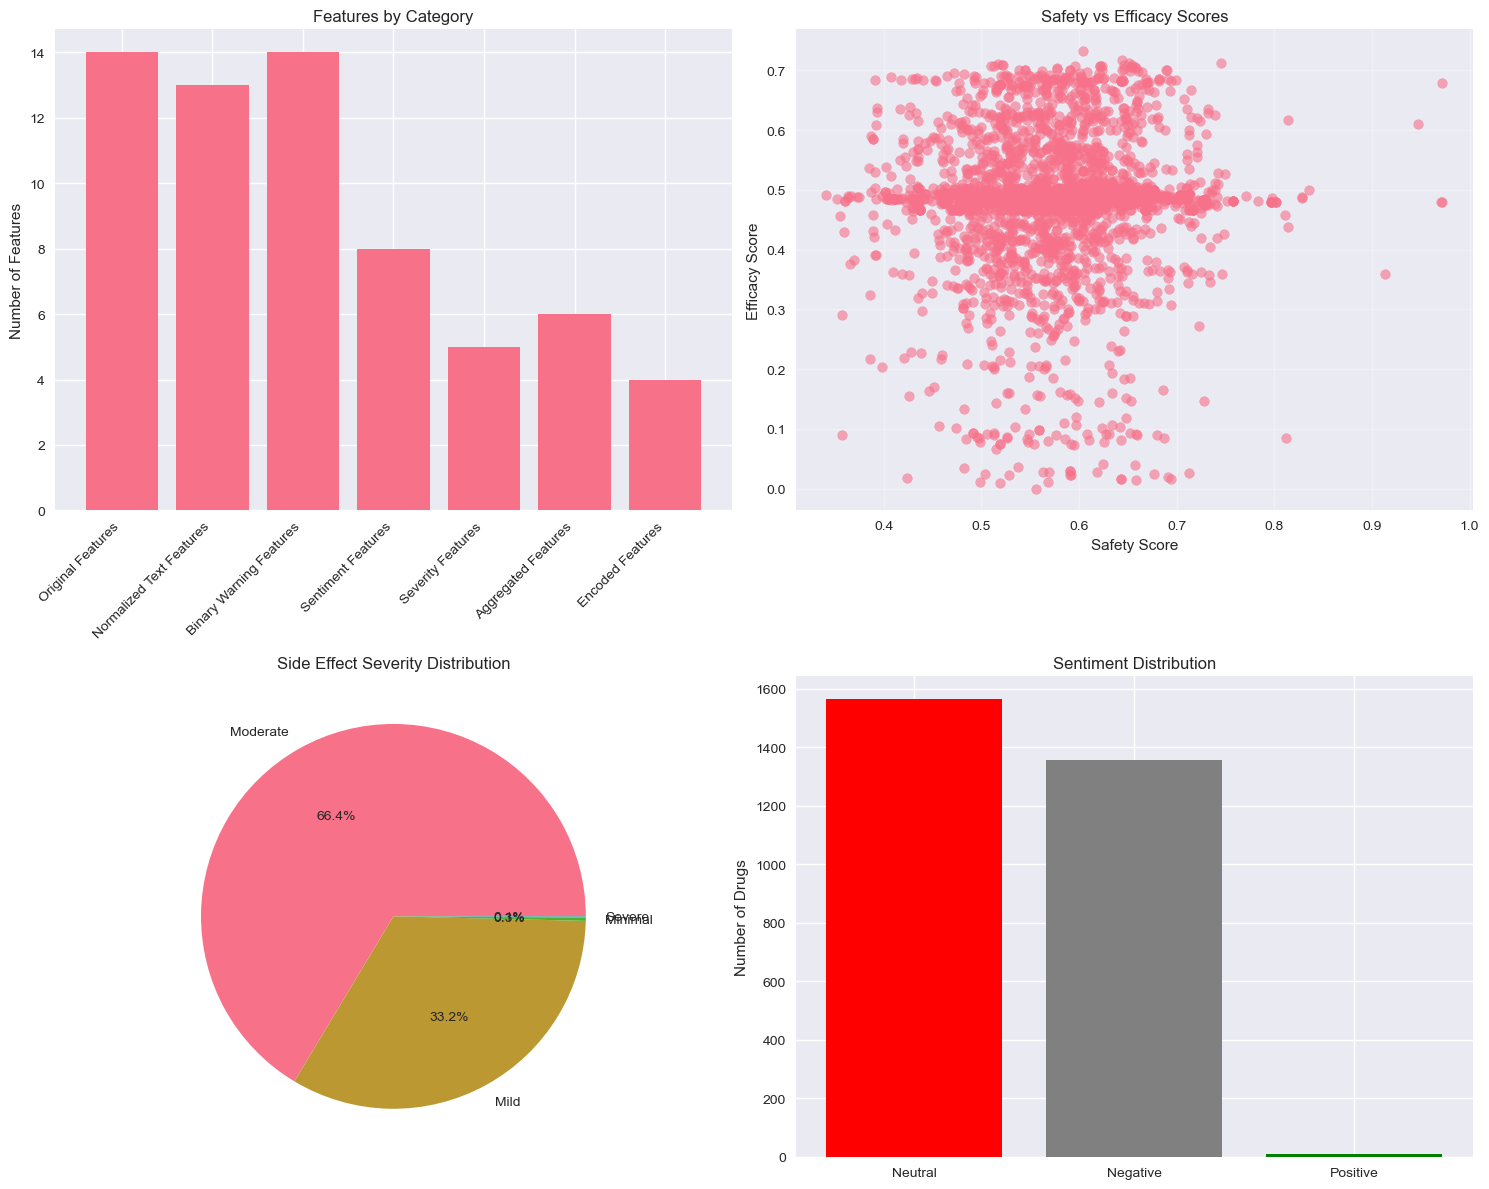

 Feature engineering visualization complete!
Data Cleaning & Feature Engineering - COMPLETED!


In [14]:
# Create visualization of the feature engineering process
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature count by category
feature_counts = {k: len(v) for k, v in feature_categories.items() if len(v) > 0}
axes[0, 0].bar(range(len(feature_counts)), list(feature_counts.values()))
axes[0, 0].set_xticks(range(len(feature_counts)))
axes[0, 0].set_xticklabels(list(feature_counts.keys()), rotation=45, ha='right')
axes[0, 0].set_title('Features by Category')
axes[0, 0].set_ylabel('Number of Features')

# 2. Safety vs Efficacy Score Distribution
if 'safety_score' in df.columns and 'efficacy_score' in df.columns:
    axes[0, 1].scatter(df['safety_score'], df['efficacy_score'], alpha=0.6)
    axes[0, 1].set_xlabel('Safety Score')
    axes[0, 1].set_ylabel('Efficacy Score')
    axes[0, 1].set_title('Safety vs Efficacy Scores')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Severity Distribution
if 'severity_category' in df.columns:
    severity_counts = df['severity_category'].value_counts()
    axes[1, 0].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%')
    axes[1, 0].set_title('Side Effect Severity Distribution')

# 4. Sentiment Distribution
if 'sentiment_category' in df.columns:
    sentiment_counts = df['sentiment_category'].value_counts()
    colors = ['red', 'gray', 'green']
    axes[1, 1].bar(sentiment_counts.index, sentiment_counts.values, color=colors)
    axes[1, 1].set_title('Sentiment Distribution')
    axes[1, 1].set_ylabel('Number of Drugs')

plt.tight_layout()
plt.show()

print(" Feature engineering visualization complete!")
print("Data Cleaning & Feature Engineering - COMPLETED!")
